In [2]:
import torch 
import h5py
import numpy as np

f = h5py.File('../data/jetclass/qcd_top_jets/top_N30_100k.hdf5', 'r')
target = torch.Tensor(np.array(f['4_momenta']))
print(f.keys())

<KeysViewHDF5 ['4_momenta']>


## Dataset

In [36]:
import torch 
import h5py
import numpy as np
from torch.utils.data import Dataset
from dataclasses import dataclass, field
from typing import List

from DynGenModels.datamodules.jetclass.dataprocess import PreProcessJetClassData

@dataclass
class JetClass_Config:
    NAME : str = None
    DATASET : str = 'jetclass'
    DATA_SOURCE : str = 'qcd'
    DATA_TARGET : str = 'top'
    MAX_NUM_CONSTITUENTS : int = 30
    FEATURES : List[str] = field(default_factory = lambda : ['pt_rel, eta_rel, phi_rel'])
    DIM_INPUT : int = 3
    PREPROCESS : List[str] = field(default_factory = lambda : ['standardize'])

class JetClassDataset(Dataset):

    def __init__(self, config):
        self.data_source = config.DATA_SOURCE
        self.data_target = config.DATA_TARGET
        self.dim_input = config.DIM_INPUT
        self.features = config.FEATURES
        self.max_num_constituents = config.MAX_NUM_CONSTITUENTS
        self.preprocess_methods = config.PREPROCESS
        self.get_target_data()
        self.get_source_data()

    def __getitem__(self, idx):
        output = {}
        output['target'] = self.target_preprocess[idx]
        output['source'] = self.source_preprocess[idx]
        output['target context'] = self.jets_target[idx]
        output['source context'] = self.jets_source[idx]
        output['context'] = torch.zeros_like(output['target'][..., None:1]) #...to be replaced with jet label
        output['target mask'] = torch.ones_like(output['target'][..., None:1])
        output['source mask'] = torch.ones_like(output['source'][..., None:1])
        return output

    def __len__(self):
        return len(self.target)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_target_data(self):
        if self.data_target == 'qcd': f = h5py.File('../data/jetclass/qcd_top_jets/qcd_N30_100k.hdf5', 'r') 
        elif self.data_target == 'top': f = h5py.File('../data/jetclass/qcd_top_jets/top_N30_100k.hdf5', 'r')
        constituents = torch.Tensor(np.array(f['4_momenta']))[..., :4]
        jets = torch.sum(constituents, dim=1)
        self.jets_target = self.get_features(jets)
        jet_axis = jets.unsqueeze(1).repeat(1, self.max_num_constituents, 1)        
        data = PreProcessJetClassData(self.get_features(constituents, axis=jet_axis, flatten_tensor=True), 
                                      contituents=True, 
                                      methods=self.preprocess_methods)      

        self.target = data.features.clone()
        data.preprocess()
        self.summary_stats = data.summary_stats
        self.target_preprocess = data.features.clone()

    def get_source_data(self):
        if self.data_source == 'qcd': f = h5py.File('../data/jetclass/qcd_top_jets/qcd_N30_100k.hdf5', 'r') 
        elif self.data_source == 'top': f = h5py.File('../data/jetclass/qcd_top_jets/top_N30_100k.hdf5', 'r')
        constituents = torch.Tensor(np.array(f['4_momenta']))[..., :4]
        jets = torch.sum(constituents, dim=1)
        self.jets_source = self.get_features(jets)
        jet_axis = jets.unsqueeze(1).repeat(1, self.max_num_constituents, 1)        
        data = PreProcessJetClassData(self.get_features(constituents, axis=jet_axis, flatten_tensor=True), 
                                      contituents=True, 
                                      methods=self.preprocess_methods)  
            
        self.source = data.features.clone()
        data.preprocess()
        self.source_preprocess = data.features.clone()
        
    def get_features(self, four_mom, axis=None, flatten_tensor=False):
        four_mom = four_mom.reshape(-1,4) if flatten_tensor else four_mom
        px, py, pz, e = four_mom[...,0], four_mom[...,1], four_mom[...,2], four_mom[...,3]
        pt = torch.sqrt(px**2 + py**2)
        eta = 0.5 * np.log( (e + pz) / (e - pz))
        phi = np.arctan2(py, px)
        m = torch.sqrt(e**2 - px**2 - py**2 - pz**2)
        
        if axis is not None:
            axis = axis.reshape(-1,4) if flatten_tensor else axis
            px_axis, py_axis, pz_axis, e_axis = axis[...,0], axis[...,1], axis[...,2], axis[...,3]
            pt_axis = torch.sqrt(px_axis**2 + py_axis**2)
            eta_axis = 0.5 * np.log( (e_axis + pz_axis) / (e_axis - pz_axis))
            phi_axis= np.arctan2(py_axis, px_axis)
            m_axis = torch.sqrt(e_axis**2 - px_axis**2 - py_axis**2 - pz_axis**2)
            #...coords relative to axis:
            pt = pt / pt_axis
            eta = eta - eta_axis
            phi = (phi - phi_axis + np.pi) % (2 * np.pi) - np.pi
            m = m / m_axis

        hadr_coord = torch.stack([pt, eta, phi, m], dim=1)
        output = hadr_coord.reshape(-1, self.max_num_constituents, 4) if flatten_tensor else hadr_coord

        return output


In [37]:
from typing import Any
import torch
import numpy as np

class PreProcessJetClassData:

    def __init__(self, 
                 features,
                 contituents: bool=True,
                 summary_stats: dict=None,
                 methods: list=None
                 ):
        
        self.features = features[...,:-1] if contituents else features # remove the mass of constituents
        self.methods = methods
        self.summary_stats = {} if summary_stats is None else summary_stats

    def preprocess(self):      
        if self.methods is not None:
            for method in self.methods:
                method = getattr(self, method, None)
                if method and callable(method): method()
                else: raise ValueError('Preprocessing method {} not implemented'.format(method))
        else: pass
    
    def standardize(self,  sigma: float=1.0):
        """ standardize data to have zero mean and unit variance
        """
        self.summary_stats['mean'] = self.features.view(-1, self.features.shape[-1]).mean(dim=0)
        self.summary_stats['std'] = self.features.view(-1, self.features.shape[-1]).std(dim=0)
        self.features = (self.features - self.summary_stats['mean']) * (sigma / self.summary_stats['std'])

    def normalize(self):
        """ normalize data to unit interval
        """
        self.summary_stats['min'], _ = torch.min(self.features, dim=0)
        self.summary_stats['max'], _ = torch.max(self.features, dim=0)
        self.features = (self.features - self.summary_stats['min']) / ( self.summary_stats['max'] - self.summary_stats['min'])
    
    def logit_transform(self, alpha=1e-5):
        """ smoothen rectified distribution with logit transform
        """
        self.features = self.features * (1 - 2 * alpha) + alpha
        self.features = torch.log(self.features / (1 - self.features))

In [38]:
jetclass = JetClassDataset(JetClass_Config())
dataloader = torch.utils.data.DataLoader(jetclass, batch_size=32, shuffle=True)
jetclass.source.shape, jetclass.target.shape

(torch.Size([100000, 30, 3]), torch.Size([100000, 30, 3]))

In [39]:
jetclass.jets_source

tensor([[ 4.8761e+02, -4.1098e-01, -9.0902e-01,  3.6414e+01],
        [ 5.8291e+02,  6.3607e-01,  8.6484e-01,  6.0763e+01],
        [ 4.5593e+02,  1.1378e+00, -2.4190e+00,  5.5145e+01],
        ...,
        [ 5.9189e+02, -6.8251e-01, -8.3100e-01,  1.2415e+02],
        [ 6.6366e+02,  8.1128e-02,  3.5414e-02,  4.7693e+01],
        [ 8.2545e+02,  6.0978e-01, -1.6251e+00,  7.8428e+01]])

In [40]:
for batch in dataloader:
    print(batch['source'].shape)
    print(batch['source mask'].shape)
    print(batch['source context'].shape)

    print(batch['target'].shape)
    print(batch['target mask'].shape)
    print(batch['target context'].shape)

    print(batch['context'].shape)

    break 

torch.Size([32, 30, 3])
torch.Size([32, 30, 1])
torch.Size([32, 4])
torch.Size([32, 30, 3])
torch.Size([32, 30, 1])
torch.Size([32, 4])
torch.Size([32, 30, 1])


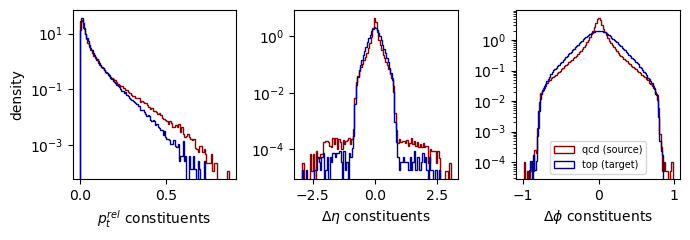

In [39]:
import matplotlib.pyplot as plt

num_particles=1000000

_, axs = plt.subplots(1, 3, figsize=(7, 2.5))
axs[0].hist(jetclass.source[..., 0].flatten()[:num_particles], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[0].hist(jetclass.target[..., 0].flatten()[:num_particles], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[1].hist(jetclass.source[..., 1].flatten()[:num_particles], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[1].hist(jetclass.target[..., 1].flatten()[:num_particles], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[2].hist(jetclass.source[..., 2].flatten()[:num_particles], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[2].hist(jetclass.target[..., 2].flatten()[:num_particles], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[0].set_xlabel(r'$p_t^{rel}$ constituents')
axs[1].set_xlabel(r'$\Delta\eta$ constituents')
axs[2].set_xlabel(r'$\Delta\phi$ constituents')
axs[0].set_ylabel('density')
axs[2].legend(loc='lower center', fontsize=7)
plt.tight_layout()
plt.show()

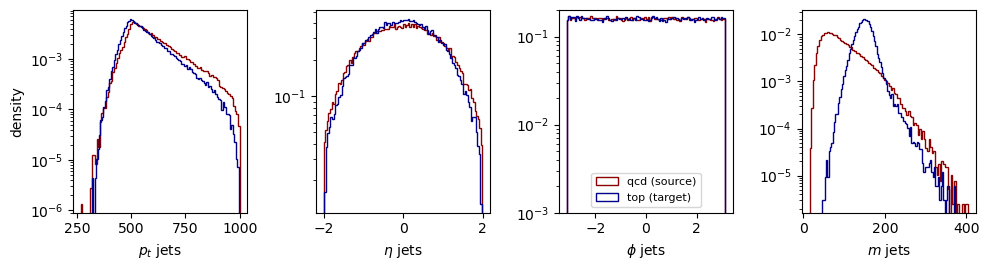

In [8]:
import matplotlib.pyplot as plt

num_jets=1000000

_, axs = plt.subplots(1, 4, figsize=(10, 2.8))
axs[0].hist(jetclass.jets_source[..., 0], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[0].hist(jetclass.jets_target[..., 0], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[1].hist(jetclass.jets_source[..., 1][:num_jets], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[1].hist(jetclass.jets_target[..., 1][:num_jets], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[2].hist(jetclass.jets_source[..., 2][:num_jets], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[2].hist(jetclass.jets_target[..., 2][:num_jets], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[3].hist(jetclass.jets_source[..., 3][:num_jets], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[3].hist(jetclass.jets_target[..., 3][:num_jets], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[0].set_xlabel(r'$p_t$ jets')
axs[1].set_xlabel(r'$\eta$ jets')
axs[2].set_xlabel(r'$\phi$ jets')
axs[2].set_ylim(0.001, 0.2)
axs[3].set_xlabel(r'$m$ jets')
axs[0].set_ylabel('density')
axs[2].legend(loc='lower center', fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
context = jetclass.jets_target - jetclass.jets_source / (jetclass.jets_target + jetclass.jets_source)

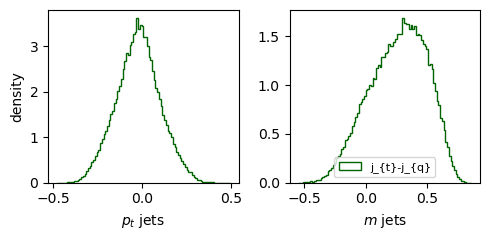

In [29]:
import matplotlib.pyplot as plt

num_jets=1000000
log = False

_, axs = plt.subplots(1, 2, figsize=(5, 2.5))
axs[0].hist((jetclass.jets_target[..., 0] - jetclass.jets_source[..., 0])/(jetclass.jets_target[..., 0] + jetclass.jets_source[..., 0]), bins=100,log=log, color='darkgreen', histtype='step', label='$j_{t}-j_{q}$', density=True)
axs[1].hist((jetclass.jets_target[..., 3] - jetclass.jets_source[..., 3])/(jetclass.jets_target[..., 3] + jetclass.jets_source[..., 3]), bins=100,log=log, color='darkgreen', histtype='step', label='j_{t}-j_{q}', density=True)
axs[0].set_xlabel(r'$p_t$ jets')
axs[1].set_xlabel(r'$m$ jets')
axs[0].set_ylabel('density')
axs[1].legend(loc='lower center', fontsize=8)
plt.tight_layout()
plt.show()

## Preprocessing

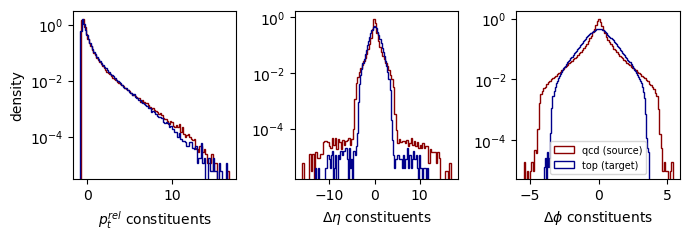

In [9]:
import matplotlib.pyplot as plt

num_particles=1000000

_, axs = plt.subplots(1, 3, figsize=(7, 2.5))
axs[0].hist(jetclass.source_preprocess[..., 0].flatten()[:num_particles], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[0].hist(jetclass.target_preprocess[..., 0].flatten()[:num_particles], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[1].hist(jetclass.source_preprocess[..., 1].flatten()[:num_particles], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[1].hist(jetclass.target_preprocess[..., 1].flatten()[:num_particles], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[2].hist(jetclass.source_preprocess[..., 2].flatten()[:num_particles], bins=100,log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
axs[2].hist(jetclass.target_preprocess[..., 2].flatten()[:num_particles], bins=100,log=True, color='darkblue', histtype='step', label='top (target)', density=True)
axs[0].set_xlabel(r'$p_t^{rel}$ constituents')
axs[1].set_xlabel(r'$\Delta\eta$ constituents')
axs[2].set_xlabel(r'$\Delta\phi$ constituents')
axs[0].set_ylabel('density')
axs[2].legend(loc='lower center', fontsize=7)
plt.tight_layout()
plt.show()